In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-hmez4bsy
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-hmez4bsy
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=cde4db811852a948e321a1425dd5cda26ddf51c1295f284994a8fd92501c6368
  Stored in directory: /tmp/pip-ephem-wheel-cache-aukcpkbs/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers import CRF

Using TensorFlow backend.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM,GRU, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import model_from_json

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Data Preparation

In [ ]:
!wget "https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio" -P "/tmp/"


--2020-08-02 09:37:17--  https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1785558 (1.7M)
Saving to: ‘/tmp/trivia10k13train.bio’

trivia10k13train.bi 100%[===================>]   1.70M  1.28MB/s    in 1.3s    

2020-08-02 09:37:20 (1.28 MB/s) - ‘/tmp/trivia10k13train.bio’ saved [1785558/1785558]



In [ ]:
!wget "https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio" -P "/tmp/"

--2020-08-02 09:37:21--  https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438729 (428K)
Saving to: ‘/tmp/trivia10k13test.bio’

trivia10k13test.bio 100%[===================>] 428.45K   554KB/s    in 0.8s    

2020-08-02 09:37:23 (554 KB/s) - ‘/tmp/trivia10k13test.bio’ saved [438729/438729]



In [ ]:
## Read input training data
with open ("/tmp/trivia10k13train.bio", "r") as f:
    lines = [eachLine.rstrip() for eachLine in f]

## Prepare word list, tag list and tuple of sentences
sentences=[]
eachSentence=[]
words=[]
tags=[]
for eachline in lines:
  if eachline != '':
    eachTag,eachWord = eachline.split('\t')
    words.append(eachWord)
    tags.append(eachTag)
    eachSentence.append((eachWord,eachTag))
  else:
    sentences.append(eachSentence)
    eachSentence = []

## Remove duplicates. Add - OOV(out of vocab) ENDPAD to word list
words = list(set(words))
words.append("OOV")
words.append("ENDPAD")
tags = list(set(tags))

num_words = len(words)
num_tags = len(tags)

In [ ]:
## Print number of words and number of tags
num_words, num_tags

(10989, 25)

In [ ]:
## Create word and tag dictionaries
word2idx = {w: i+1 for i,w in enumerate(words)}
tags2idx = {t: i for i,t in enumerate(tags)}

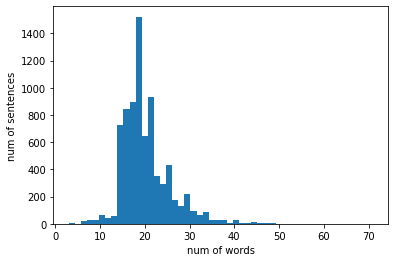

In [ ]:
## Plt the sentence lengths to understand padding requirement
plt.hist([len(s) for s in sentences], bins=50)
plt.ylabel('num of sentences')
plt.xlabel('num of words')
plt.show()

In [ ]:
## set max length to 45 and generate word sequences with padding. I have chosen post padding.
## Set the padding values to 'ENDPAD' for input and 'O' for tags.

max_len = 45
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len,sequences=X, padding='post', value=num_words-1)

y = [[tags2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tags2idx["O"])


In [ ]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
## Create train and validation split from training set
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [ ]:
## Function for model defnition with hyperparameters as arguments
def model_defnition(regularization='l2',recurrent_dropout=0.0,embed_outdim=64,num_tags=num_tags,num_words=num_words):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=num_words, output_dim=64,
                      input_length=max_len)(input)
    model = Bidirectional(LSTM(units=64, return_sequences=True,
                               recurrent_dropout=recurrent_dropout))(model)  # variational biLSTM
    model = TimeDistributed(Dense(64, activation="relu",kernel_regularizer=regularization))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(num_tags)  # CRF layer
    out = crf(model)

    model = Model(input, out)

    return (model,crf)
    

In [ ]:
### Prepare a grid of hyperparameters 
recurrentDropoutRange = [0.1, 0.3, 0.5]
maxLenRange = [45]

hyperParameterGrid = []
for i in recurrentDropoutRange:
    for j in maxLenRange:
        hyperParameterGrid.append((i,j))

In [ ]:
## Execute model fit for the range of hyper parameters and save the history for each run
## Also save the each model so that, they can be loaded at a later stage
history_hyper_all = []
for eachRecurrDropout, eachMaxLen in hyperParameterGrid:
    
    max_len = eachMaxLen
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=max_len,sequences=X, padding='post', value=num_words-1)

    y = [[tags2idx[w[1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tags2idx["O"])
    
    y = [to_categorical(i, num_classes=num_tags) for i in y]

    #x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
    
    
    model,crf = model_defnition(regularization='l2',recurrent_dropout=eachRecurrDropout)
    
    early_stopping = EarlyStopping(monitor='val_crf_viterbi_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=True)
    
    #model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
    history = model.fit(x=X, y=np.array(y), validation_split=0.1,
                        batch_size=32,epochs=30,callbacks=[early_stopping],verbose=1)
    modelName = 'Model_SpatialDropout_'+str(eachSpatialDropout)+'_RecurDropout_'+str(eachRecurrDropout)+'_MaxLen_'+str(eachMaxLen)
    history_hyper_all.append((modelName,history))
    
    ##save model
    model_json = model.to_json()
    with open("/tmp/"+modelName+".json","w") as json_file:
        json_file.write(model_json)
        
    model.save_weights("/tmp/"+modelName+".h5")
    
    #print(modelName)
    #break

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7034 samples, validate on 782 samples
Epoch 1/30
7034/7034 [==============================] - 82s 12ms/step - loss: 0.9713 - crf_viterbi_accuracy: 0.7805 - val_loss: 0.5649 - val_crf_viterbi_accuracy: 0.8407
Epoch 2/30
7034/7034 [==============================] - 83s 12ms/step - loss: 0.4261 - crf_viterbi_accuracy: 0.8695 - val_loss: 0.3663 - val_crf_viterbi_accuracy: 0.8769
Epoch 3/30
7034/7034 [==============================] - 80s 11ms/step - loss: 0.2948 - crf_viterbi_accuracy: 0.8985 - val_loss: 0.2597 - val_crf_viterbi_accuracy: 0.9083
Epoch 4/30
7034/7034 [==============================] - 81s 11ms/step - loss: 0.2166 - crf_viterbi_accuracy: 0.9175 - val_loss: 0.1980 - val_crf_viterbi_accuracy: 0.9178
Epoch 5/30
7034/7034 [==============================] - 82s 12ms/step - loss: 0.1692 - crf_viterbi_accuracy: 0.9255 - val_loss: 0.1598 - val_crf_viterbi_accuracy: 0.9243
Epoch 6/30
7034/7034 [==============================] - 83s 12ms/step - loss: 0.1351 - crf_viterbi_accu

In [ ]:
### Save the history parameters - accuracy, val_accuracy, loss and val_loss into a dataframe and save for further reference.
eval_list = []
for eachHistoryName, eachHistory in history_hyper_all:
    for eachItem in zip(eachHistory.history['crf_viterbi_accuracy'],eachHistory.history['val_crf_viterbi_accuracy'],eachHistory.history['loss'],eachHistory.history['val_loss']):
        eval_list.append(eachItem + (eachHistoryName,))

df_history_eval = pd.DataFrame(eval_list)
df_history_eval.to_csv('/tmp/history_eval.csv',index=False) 

In [ ]:
## Verify the metrics - val_accuracy for different iterations
df_history_eval = pd.read_csv('/tmp/history_eval.csv',encoding='utf-8')
df_history_eval.columns = ['crf_viterbi_accuracy','val_crf_viterbi_accuracy','loss','val_loss','iteration']
df_history_eval['epoch'] = df_history_eval.groupby(['iteration']).cumcount()
df_history_eval.groupby(['iteration'])['val_crf_viterbi_accuracy'].max()

iteration
Model_SpatialDropout_0.5_RecurDropout_0.1_MaxLen_45    0.932667
Model_SpatialDropout_0.5_RecurDropout_0.3_MaxLen_45    0.931048
Model_SpatialDropout_0.5_RecurDropout_0.5_MaxLen_45    0.933929
Name: val_crf_viterbi_accuracy, dtype: float64

Run the model on test dataset and check the performance

In [ ]:
## Read and prepare test data to run predictions
with open ("/tmp/trivia10k13test.bio", "r") as f:
    lines = [eachLine.rstrip() for eachLine in f]

## Prepare word list, tag list and tuple of sentences
testSentences=[]
eachSentence=[]
testWords=[]
testTags=[]
i=0
testSentencesforDF = []
for eachline in lines:
  if eachline != '':
    eachTag,eachWord = eachline.split('\t')
    testWords.append(eachWord)
    testTags.append(eachTag)
    eachSentence.append((eachWord,eachTag))
    testSentencesforDF.append(('sentence'+str(i),eachWord,eachTag))
  else:
    i+=1
    testSentences.append(eachSentence)
    eachSentence = []
  
testWords = list(set(testWords))
testTags = list(set(testTags))

## Apply padding. For new words not seen in train dataset, treat it as OOV
X_test = [[word2idx[w[0]] if w[0] in words else word2idx["OOV"] for w in s] for s in testSentences]
X_test = pad_sequences(maxlen=max_len,sequences=X_test, padding='post', value=num_words-1)

y_test = [[tags2idx[w[1]] for w in s] for s in testSentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding='post', value=tags2idx["O"])
y_test = [to_categorical(i, num_classes=num_tags) for i in y_test]

In [ ]:
##Evaluate the model
model.evaluate(X_test,np.array(y_test))

1953/1953 [==============================] - 3s 2ms/step


[0.09426452564547688, 0.9126344323158264]

In [ ]:
!pip install seqeval

In [ ]:
loaded_model = model

In [ ]:
## Prepare the csv file with predictions and actuals

predvsact=[]
p = loaded_model.predict(np.array(X_test))
for i in range(len(X_test)):
  #print(i)
  eachPred = p[i]
  eachPred = np.argmax(eachPred, axis=-1)
  for w, act, pred in zip(X_test[i], y_test[i], eachPred):
      if words[w - 1] != "PADword":
        predvsact.append(('sentence'+str(i),words[i-1], tags[pred], tags[list(act).index(1)]))
  #break

df_predvsact = pd.DataFrame(predvsact,columns=['sentence#','word','predicted','actual'])
df_predvsact['wordcount'] = df_predvsact.groupby(['sentence#']).cumcount()

df_testSentences = pd.DataFrame(testSentencesforDF,columns=['sentence#','word_test','tag'])
df_testSentences['wordcount'] = df_testSentences.groupby(['sentence#']).cumcount()

df_test_predvsact = pd.merge(df_testSentences,df_predvsact,how='inner',on=['sentence#','wordcount'],sort=False)

#df_test_predvsact = df_test_predvsact.drop(['tag','wordcount'],axis=1)
df_test_predvsact = df_test_predvsact.rename(columns={'word':'wordconv'})

df_test_predvsact.to_csv('/tmp/testdataset_withpred.csv',index=False)

In [ ]:
df_classification_report = pd.DataFrame(classification_report(df_test_predvsact['actual'],df_test_predvsact['predicted'],output_dict=True)).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_classification_report

,precision,recall,f1-score,support
B-Actor,0.892188,0.897799,0.894984,1272.00000
B-Award,0.764706,0.590909,0.666667,66.00000
B-Character_Name,0.441989,0.283688,0.345572,282.00000
B-Director,0.792237,0.816471,0.804171,425.00000
B-Genre,0.758178,0.822560,0.789058,789.00000
B-Opinion,0.306122,0.076923,0.122951,195.00000
B-Origin,0.481481,0.342105,0.400000,190.00000
B-Plot,0.473762,0.406468,0.437543,1577.00000
B-Quote,0.000000,0.000000,0.000000,46.00000
B-Relationship,0.916667,0.064706,0.120879,170.00000


In [ ]:
accuracy_score(df_test_predvsact['actual'],df_test_predvsact['predicted'])

0.786220169361047

Others

In [ ]:
from google.colab import files
uploaded = files.upload()